In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Concatenate, Input

In [ ]:
mg = Sequential()

mg.add(Input(shape=(4,84,84)))
mg.add(Conv2D(32, (8,8), strides=(4,4), activation="relu"))
mg.add(Conv2D(64, (4,4), strides=(2,2), activation="relu"))
mg.add(Conv2D(64, (3,3), strides=(1,1), activation="relu"))

mg.add(Flatten())


In [ ]:
mg.summary()

In [ ]:
ml = Sequential()

ml.add(Input(shape=(11,11,1)))
ml.add(Conv2D(128, (11,11)))
ml.add(Flatten())

In [ ]:
ml.summary()

In [ ]:
x = Concatenate(axis=1)([ml.output, mg.output])
model = Sequential()
model.add(Input(shape=x.shape))

model.add(Dense(256, activation="relu"))
model.add(Dense(242, activation="softmax"))

In [ ]:
model.summary()

In [ ]:
x.shape

In [ ]:
ml.output_shape[1] + mg.output_shape[1]

In [ ]:
import numpy as np
np.add(ml.output_shape, mg.output_shape)

In [ ]:
model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
from tensorflow import keras
logdir="aaa" 
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Concatenate, Input

class DoodleSDQModel(Model):
    def __init__(self, global_input_size, local_input_size, output_size):
        super(DoodleSDQModel, self).__init__()
        self.global_input_size = global_input_size
        self.local_input_size = local_input_size
        self.output_size = output_size

        self.model_global = self._create_global_CNN()
        self.model_local = self._create_local_CNN()
        self.dense = self._create_dense()

    def _create_global_CNN(self):
        model = Sequential()
        model.add(Input(shape=self.global_input_size))
        model.add(Conv2D(32, (8,8), strides=(4,4), activation="relu"))
        model.add(Conv2D(64, (4,4), strides=(2,2), activation="relu"))
        model.add(Conv2D(64, (3,3), strides=(1,1), activation="relu"))
        return model

    def _create_local_CNN(self):
        model = Sequential()
        model.add(Input(shape=self.local_input_size))
        model.add(Conv2D(128, (11,11), activation="relu"))
        return model

    def _create_dense(self):
        input_shape = (None, self.model_global.output_shape[1] + self.model_local.output_shape[1])
        model = Sequential()
        model.add(Input(shape=input_shape))
        model.add(Dense(256, activation="relu"))
        model.add(Dense(self.output_size, activation="softmax"))
        return model

    def call(self, inputs, patches):
        print("call")
        global_input = inputs
        local_input = patches
        global_features = self.model_global(global_input)
        local_features = self.model_local(local_input)
        
        x = Concatenate(axis=1)([global_features, local_features])
        y_pred = self.dense(x)
        
        return y_pred


In [ ]:
import matplotlib.pyplot as plt

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Concatenate, Input, MaxPool2D, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import numpy as np

class DoodleSDQModel():
    def __init__(self, global_input_size, local_input_size, output_size):
        #super(DoodleSDQModel, self).__init__()
        self.global_input_size = global_input_size
        self.local_input_size = local_input_size
        self.output_size = output_size
        
        self.model = self._create_model()
        
        # class weight: down=1, up=0.5
        self.class_weight = {i:1 if i<121 else 0.5 for i in range(output_size)}
        
        
    def _create_model(self):
        local_input = tf.keras.Input(shape=self.local_input_size)
        global_input = tf.keras.Input(shape=self.global_input_size)
        
        inputs = [global_input, local_input]
        
        x_local = self._create_local_CNN(local_input)
        x_global = self._create_global_CNN(global_input)
        
        x = Concatenate(axis=1)([x_global, x_local])
        
        x = Dense(2048)(x)
        x = Dropout(.5)(x)
        x = Activation("relu")(x)
        x = Dense(self.output_size)(x)
        outputs = Activation("softmax") (x)
        return Model(inputs, outputs, name="doodle_dqn")

    def _create_global_CNN(self, input):
        
        x = Conv2D(32, (8,8), strides=(4,4), padding='same')(input)
        x = Activation("relu")(x)
        
        x = Conv2D(64, (4,4), strides=(2,2), padding='same')(x)
        x = Activation("relu")(x)
        
        x = Conv2D(64, (3,3), strides=(1,1), padding='same')(x)
        x = Activation("relu")(x)
        
        x = Flatten()(x)
        
        return x

    def _create_local_CNN(self, input):
        x = Conv2D(128, (11,11), padding='same')(input)
        x = Activation("relu")(x)
        
        x = Flatten()(x)
        return x
    
    def train(self,training_gen, validation_data, epochs, init_epoch=0):
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, verbose=1)
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1)
        tensorboard = TensorBoard(
                              log_dir='logs/layer2048-242-weights',
                              histogram_freq=0,
                              write_images=True
                            )
        
        self.epochs = epochs
        self.model.compile(optimizer=Adam(lr=.003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.history = self.model.fit(training_gen,\
                                      validation_data=validation_data, \
                                      validation_steps= len(validation_data),\
                                      epochs=epochs, \
                                      initial_epoch=init_epoch,\
                                      callbacks=[reduce_lr, early_stopping, tensorboard], \
#                                       class_weight=self.class_weight, \
                                      verbose=1)
    
    def plot(self):
        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']

        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        epochs_range = range(self.epochs)

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()
#     def _create_dense(self):
#         input_shape = (None, self.model_global.output_shape[1] + self.model_local.output_shape[1])
#         model = Sequential()
#         model.add(Input(shape=input_shape))
#         model.add(Dense(256, activation="relu"))
#         model.add(Dense(self.output_size, activation="softmax"))
#         return model

#     def call(self, inputs, patches):
#         print("call")
#         global_input = inputs
#         local_input = patches
#         global_features = self.model_global(global_input)
#         local_features = self.model_local(local_input)
        
#         x = Concatenate(axis=1)([global_features, local_features])
#         y_pred = self.dense(x)
        
#         return y_pred


In [2]:
from random_stroke_generator import RandomStrokeGenerator

In [3]:
training_gen = RandomStrokeGenerator(batch_size=484,num_data=4840, min_strokes=4, max_strokes=16)
valid_gen = RandomStrokeGenerator(batch_size=242, num_data=484, min_strokes=4, max_strokes=16)

In [4]:
global_size = (84,84,4)
local_size = (11,11,2)
model1 = DoodleSDQModel(global_input_size=global_size, local_input_size=local_size, output_size=242)


In [10]:
model1.model.summary()

Model: "doodle_dqn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 84, 84, 4)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 21, 21, 32)   8224        input_4[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 21, 21, 32)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 11, 11, 64)   32832       activation_7[0][0]               
_________________________________________________________________________________________

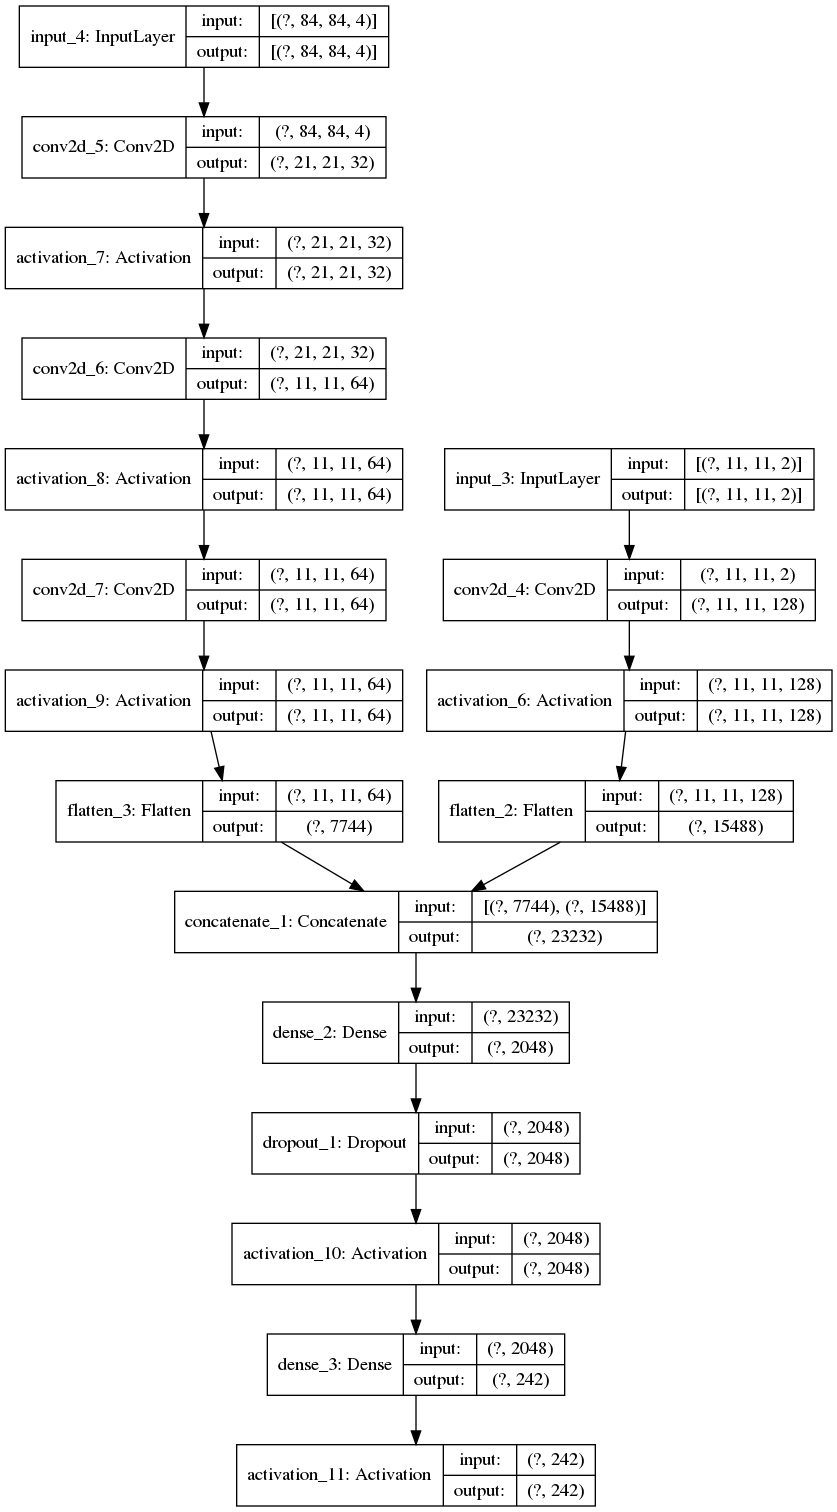

In [11]:
from tensorflow import keras

keras.utils.plot_model(model1.model, "doodle_sdq.png", show_shapes=True)

In [23]:
model1.train(training_gen, valid_gen, 100, init_epoch=0)

Epoch 1/100
10/10 [==============================] - 1s 74ms/step - loss: 5.6606 - accuracy: 0.0105 - val_loss: 5.4858 - val_accuracy: 0.0103 - lr: 0.0030
Epoch 2/100
10/10 [==============================] - 1s 54ms/step - loss: 5.4778 - accuracy: 0.0107 - val_loss: 5.4437 - val_accuracy: 0.0083 - lr: 0.0030
Epoch 3/100
10/10 [==============================] - 1s 54ms/step - loss: 5.2740 - accuracy: 0.0287 - val_loss: 4.8516 - val_accuracy: 0.0599 - lr: 0.0030
Epoch 4/100
10/10 [==============================] - 1s 54ms/step - loss: 4.4652 - accuracy: 0.1031 - val_loss: 4.0054 - val_accuracy: 0.1674 - lr: 0.0030
Epoch 5/100
10/10 [==============================] - 1s 55ms/step - loss: 3.9079 - accuracy: 0.1791 - val_loss: 3.4910 - val_accuracy: 0.2603 - lr: 0.0030
Epoch 6/100
10/10 [==============================] - 1s 53ms/step - loss: 3.6497 - accuracy: 0.2430 - val_loss: 3.4574 - val_accuracy: 0.2996 - lr: 0.0030
Epoch 7/100
10/10 [==============================] - 1s 55ms/step - lo

Epoch 51/100
10/10 [==============================] - 1s 54ms/step - loss: 2.7349 - accuracy: 0.4694 - val_loss: 2.4187 - val_accuracy: 0.5000 - lr: 2.7000e-04
Epoch 52/100
10/10 [==============================] - 1s 54ms/step - loss: 2.7757 - accuracy: 0.4653 - val_loss: 2.6551 - val_accuracy: 0.4628 - lr: 2.7000e-04
Epoch 53/100
10/10 [==============================] - 1s 55ms/step - loss: 2.7048 - accuracy: 0.4700 - val_loss: 2.3524 - val_accuracy: 0.5248 - lr: 2.7000e-04
Epoch 54/100
10/10 [==============================] - 1s 55ms/step - loss: 2.6474 - accuracy: 0.4812 - val_loss: 2.5805 - val_accuracy: 0.4897 - lr: 2.7000e-04
Epoch 55/100
10/10 [==============================] - 1s 53ms/step - loss: 2.7482 - accuracy: 0.4653 - val_loss: 2.5659 - val_accuracy: 0.4979 - lr: 2.7000e-04
Epoch 56/100
10/10 [==============================] - 1s 53ms/step - loss: 2.7093 - accuracy: 0.4717 - val_loss: 2.3308 - val_accuracy: 0.5351 - lr: 2.7000e-04
Epoch 57/100
10/10 [====================

In [24]:
! tensorboard --logdir "logs/layer2048/"

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.3.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [3]:
X, y = training_gen.__getitem__(1)

In [13]:
model1.model.evaluate(training_gen)

10/10 [==============================] - 1s 129ms/step - loss: 2.5271 - accuracy: 0.5012


[2.527094841003418, 0.5012396574020386]

In [14]:
model1.model.evaluate(valid_gen)

2/2 [==============================] - 0s 55ms/step - loss: 2.6251 - accuracy: 0.4938


[2.625136613845825, 0.49380165338516235]

In [16]:
pred = model1.model.predict(X)
print(pred)

[[1.19456445e-05 1.29647842e-05 1.56718706e-05 ... 3.62288779e-06
  7.25570953e-06 3.75989976e-06]
 [1.88499776e-04 1.22065423e-04 9.01418149e-01 ... 3.91715321e-06
  3.24267762e-06 2.39138831e-06]
 [2.12454688e-05 9.12299074e-05 9.19857775e-05 ... 3.03070014e-03
  1.12038525e-03 1.50602951e-03]
 ...
 [9.32544863e-05 1.05604078e-04 1.86528967e-04 ... 8.16035550e-03
  8.62279534e-03 9.45915282e-03]
 [3.73303541e-04 3.17411061e-04 5.00178605e-04 ... 1.21917354e-03
  9.92767396e-04 2.70327367e-03]
 [3.62608000e-03 1.96612746e-04 2.62462127e-04 ... 2.94101101e-05
  2.47297539e-05 4.85820165e-05]]


In [17]:
print(y)

[ 46   2  50 178 100   7 228  15 185 109 203 138 196 232  84  30  95  31
 197 133 214 183 102 202   1 171 121 100 192  93  24 150 115 205  79 190
 202  79 226 228 200  96 140 202 143  16  56 228 112 106 196  92 191 211
  20  27  41  93  99 214  80 199 211  68 230 191  90 193 196  48  54  95
 113 202  59 151  40 149 151 123   0   9  28 214  55 135  73 190 126 205
  40  41  51 215  52  15 216 229 137 163 133  91  58 221 107 101  84  92
 123 106 135  36 150 124 191   8 156  63 206 140 178 215 156  51 228 160
  21  66 214 179 185 226 206 100  47 158  56  82  32 240 119  20  35 185
 158 121 205 129 171 162 198   0  25 176  45  49  34  48 214  22 130  63
  45  12 147 238  79 238 170  50 188 100  84 175 209 227 115 179 151 119
  44   4 141  89 142  34 157  29 138 138  29 148 139  22   5  66  33 226
  28  51  19  17 187 127 189 119 206 152  20 193 131 199  49 165 113 168
 193  43  10  63  86 238 226 217  69 225 119  60   8 173 228 117 175 237
 199 126 165 112 133  85  65 202  95 201  89 207 22

In [22]:
import numpy as np
y_pred = np.argmax(pred, axis=1)
print(y_pred[y_pred!=y])

[215 122 182 153  82 206  28 209 154 237 215 210 233 156  27 122 146 116
 174  82 122 124 240  50 228  81 179 178 144 164 213 122 154 122 122  57
 230 122 199 216   5 168  12 122 195  32 137 209 169 216  50  30 187 226
 159 154 188  50 163   4 233 240  71  55 233  57  83 121 233 235 122  84
 144 185 122 233 233  48 154 122 151 203 220 158 210  57 184 118 180 126
 154 213 158  50 140 163 180  75 205 133 122  80 104 128 200 216  94  97
  48  41  85 137  55 176 172  91 154  80  93 215 237  26 216  74  52  61
  48  61 174 195 231  80 134   3 154 147 227  56 147 150 238 154 160 123
  64  69 134 211 171 166 240  50 154 143 205  93  82 131  26 152 140 190
  38 162 132  86 121 189 177 154 122  88  46 121 205 157  98 187 199  72
 204 183 164 237 154 126 125  85  70 138 178 184 122 163 157 165 185 201
 201 150  32 239 217  11  15  61 233 233 216 179 128 122  53 134 115 124
  63 122 194 152  52  22 239  39  90 233 241 145 154 211  62 169  35 196
 122 209 154 133 154 165 154 219  53 210   3 219  7

In [13]:
X2, y2 = valid_gen.__getitem__(1)

pred2 = model1.model(X2)

print(np.argmax(pred2, axis=1)==y2)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


In [22]:
import numpy as np
a = X[0][0,:,:,2]
ind = np.unravel_index(np.argmin(a), a.shape)
print(ind)


[50, 17]


In [18]:
print(84*84)

7056


In [9]:
from drawing_env import Drawer
import numpy as np

drawer = Drawer()
def draw_action(canvas, distance_map, action):
    drawer.set_canvas(canvas)
    pen_pos = np.unravel_index(np.argmin(distance_map), distance_map.shape)
    drawer.set_pen_position(pen_pos)
    drawer.do_action(action)
    return np.copy(drawer.get_canvas())
    

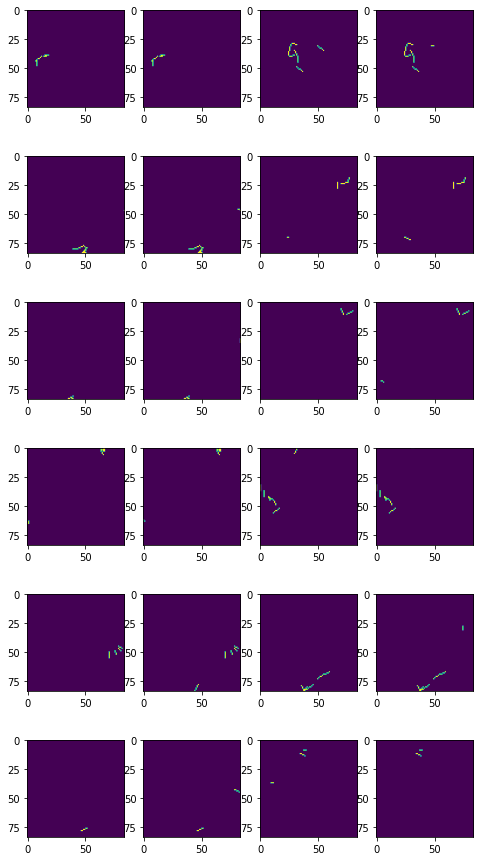

In [22]:
import matplotlib.pyplot as plt

X,y = training_gen.__getitem__(0)
pred = model1.model.predict(X)
y_pred = np.argmax(pred, axis=1)

# Plot
fig=plt.figure(figsize=(8, 64))
cols = 4
rows = 24

for i in range(12):
    canvas = X[0][i,:,:,0]
    distance_map = X[0][i,:,:,2]
    action = y[i]
    action_pred = y_pred[i]
    canv_truth = draw_action(canvas, distance_map, action)
    canv_pred = draw_action(canvas, distance_map, action_pred)
    fig.add_subplot(rows, cols, 2*i+1)
    plt.imshow(canv_truth)
    fig.add_subplot(rows, cols, 2*i+2)
    plt.imshow(canv_pred)
    
plt.show()
    

--- After training


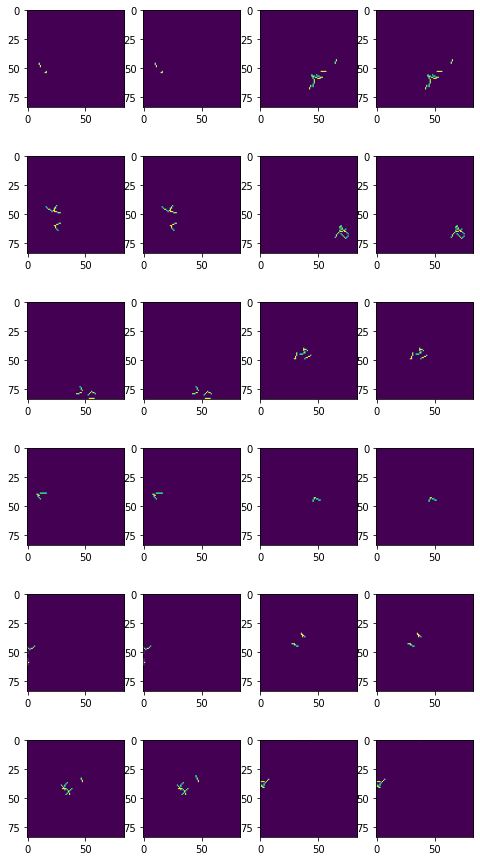

In [24]:
import matplotlib.pyplot as plt
print("--- After training")
X,y = training_gen.__getitem__(0)
pred = model1.model.predict(X)
y_pred = np.argmax(pred, axis=1)

# Plot
fig=plt.figure(figsize=(8, 64))
cols = 4
rows = 24

for i in range(12):
    canvas = X[0][i,:,:,0]
    distance_map = X[0][i,:,:,2]
    action = y[i]
    action_pred = y_pred[i]
    canv_truth = draw_action(canvas, distance_map, action)
    canv_pred = draw_action(canvas, distance_map, action_pred)
    fig.add_subplot(rows, cols, 2*i+1)
    plt.imshow(canv_truth)
    fig.add_subplot(rows, cols, 2*i+2)
    plt.imshow(canv_pred)
    
plt.show()